In [25]:
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
path = pd.read_csv("path.csv")
print(path.head(122))


     Unnamed: 0  index       x_pth       y_pth         z_pth  \
0             0    177  450.000000  700.000000  1.136868e-13   
1             1    178  450.000000  700.000000  0.000000e+00   
2             2    179  450.000000  700.000000  0.000000e+00   
3             3    180  450.000000  700.000000  0.000000e+00   
4             4    181  450.000000  700.000000  0.000000e+00   
..          ...    ...         ...         ...           ...   
117         117    294  450.000000  700.000000  0.000000e+00   
118         118    295  450.000000  700.000000  0.000000e+00   
119         119    296  450.000000  700.000000  0.000000e+00   
120         120    297  452.904966  699.539899  0.000000e+00   
121         121    298  464.524829  697.699493  0.000000e+00   

                   t_pth  
0    1633969004350000000  
1    1633969004400000000  
2    1633969004450000000  
3    1633969004500000000  
4    1633969004550000000  
..                   ...  
117  1633969010200000000  
118  1633969010

In [32]:
tracker = pd.read_csv("tracker.csv")
print(tracker.head(500))

     Unnamed: 0  index      x_trk      y_trk        z_trk                t_trk
0             0   3180 -36.507133 -40.170982 -2915.784424  1633969004633871000
1             1   3181 -36.543438 -40.260765 -2915.713623  1633969004648860000
2             2   3182 -36.645119 -40.364326 -2915.732910  1633969004662330000
3             3   3183 -36.709301 -40.413754 -2915.772949  1633969004674115000
4             4   3184 -36.720108 -40.421989 -2915.788086  1633969004687849000
..          ...    ...        ...        ...          ...                  ...
495         495   3675 -48.926826 -26.074509 -2961.823486  1633969011236526000
496         496   3676 -48.870758 -26.074509 -2961.822021  1633969011247954000
497         497   3677 -48.848335 -26.070332 -2961.819824  1633969011260401000
498         498   3678 -48.854256 -26.070070 -2961.825684  1633969011275453000
499         499   3679 -48.875694 -26.077665 -2961.834717  1633969011287840000

[500 rows x 6 columns]


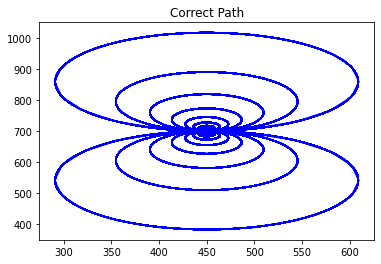

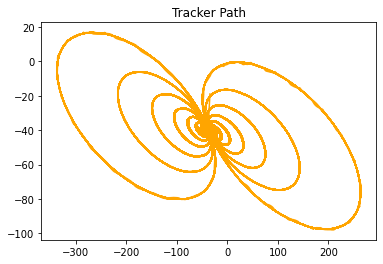

In [84]:
plt.plot(path["x_pth"], path["y_pth"], c='blue')
plt.title("Correct Path")
plt.show()

plt.plot(tracker["x_trk"], tracker["y_trk"], c='orange')
plt.title("Tracker Path")
plt.show()

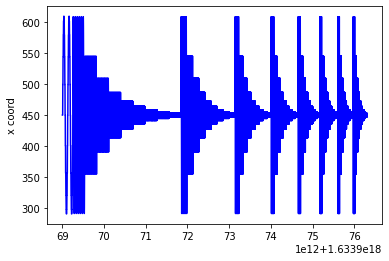

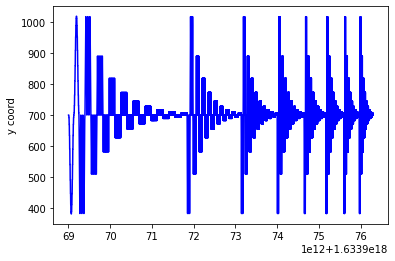

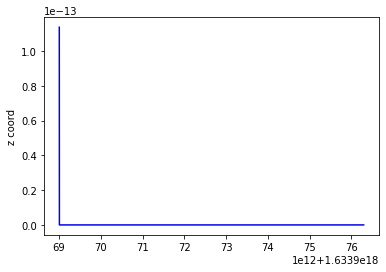

In [89]:
plt.plot(path["t_pth"], path["x_pth"], c='blue')
plt.ylabel('x coord')
plt.show()

plt.plot(path["t_pth"], path["y_pth"], c='blue')
plt.ylabel('y coord')
plt.show()

plt.plot(path["t_pth"], path["z_pth"], c='blue')
plt.ylabel('z coord')
plt.show()

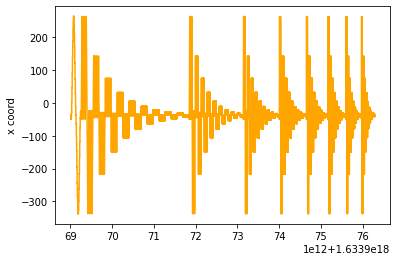

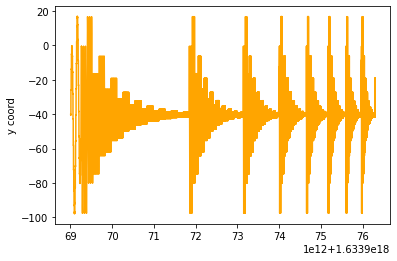

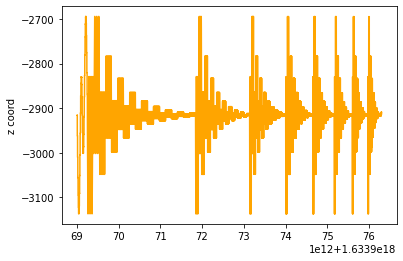

In [88]:
plt.plot(tracker["t_trk"], tracker["x_trk"], c='orange')
plt.ylabel('x coord')
plt.show()

plt.plot(tracker["t_trk"], tracker["y_trk"], c='orange')
plt.ylabel('y coord')
plt.show()

plt.plot(tracker["t_trk"], tracker["z_trk"], c='orange')
plt.ylabel('z coord')
plt.show()

In [78]:
num_points = 50000

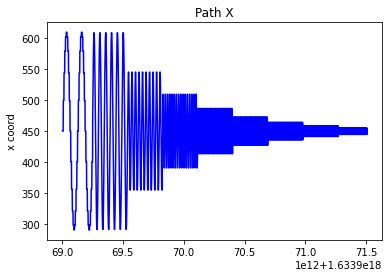

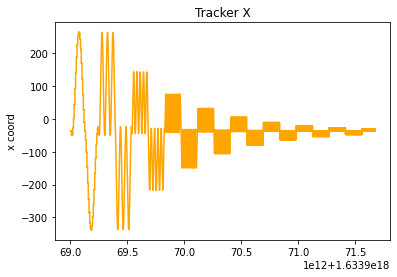

In [79]:
plt.plot(path["t_pth"][:num_points], path["x_pth"][:num_points], c='blue')
plt.ylabel('x coord')
plt.title("Path X")
plt.show()

plt.plot(tracker["t_trk"][:num_points*4], tracker["x_trk"][:num_points*4], c='orange')
plt.ylabel('x coord')
plt.title("Tracker X")
plt.show()

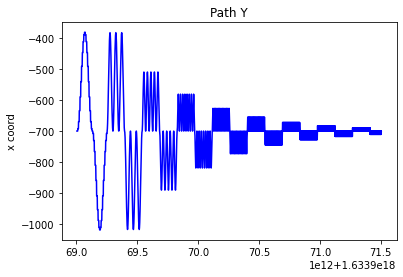

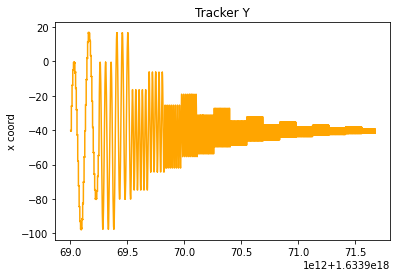

In [80]:
plt.plot(path["t_pth"][:num_points], -1*path["y_pth"][:num_points], c='blue')
plt.ylabel('x coord')
plt.title("Path Y")
plt.show()

plt.plot(tracker["t_trk"][:num_points*4], tracker["y_trk"][:num_points*4], c='orange')
plt.ylabel('x coord')
plt.title("Tracker Y")
plt.show()

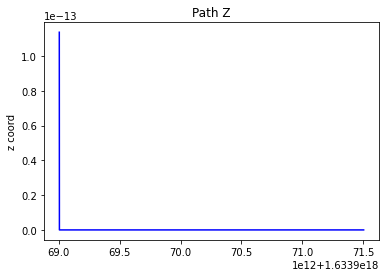

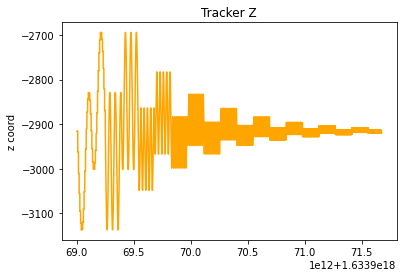

In [90]:
plt.plot(path["t_pth"][:num_points], path["z_pth"][:num_points], c='blue')
plt.ylabel('z coord')
plt.title("Path Z")
plt.show()

plt.plot(tracker["t_trk"][:num_points*4], tracker["z_trk"][:num_points*4], c='orange')
plt.ylabel('z coord')
plt.title("Tracker Z")
plt.show()

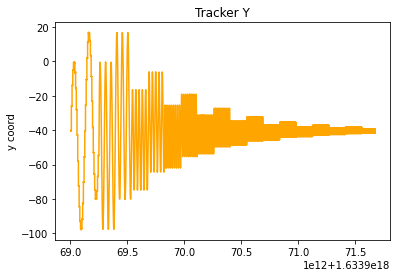

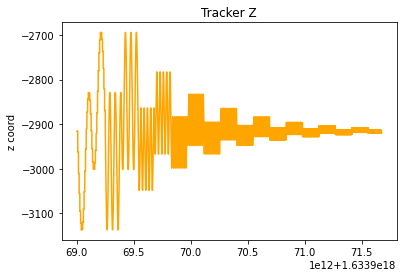

In [92]:
plt.plot(tracker["t_trk"][:num_points*4], tracker["y_trk"][:num_points*4], c='orange')
plt.ylabel('y coord')
plt.title("Tracker Y")
plt.show()

plt.plot(tracker["t_trk"][:num_points*4], tracker["z_trk"][:num_points*4], c='orange')
plt.ylabel('z coord')
plt.title("Tracker Z")
plt.show()

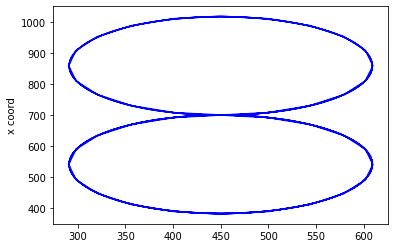

In [64]:
plt.plot(path["x_pth"][:num_points], path["y_pth"][:num_points], c='blue')
plt.ylabel('x coord')
plt.show()

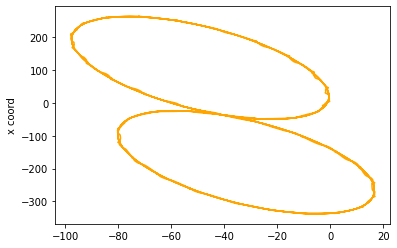

In [66]:
plt.plot(tracker["y_trk"][:num_points*4], tracker["x_trk"][:num_points*4], c='orange')
plt.ylabel('x coord')
plt.show()

In [77]:
max_path_y = max(path["y_pth"][:num_points])
min_path_y = min(path["y_pth"][:num_points])

print(max_path_y)
print(min_path_y)
print(max_path_y-min_path_y)

print()

max_trk_x = max(tracker["x_trk"][:num_points*4])
min_trk_x = min(tracker["x_trk"][:num_points*4])

print(max_trk_x)
print(min_trk_x)
print(max_trk_x-min_trk_x)

1019.6226610749832
380.37733892501694
639.2453221499662

264.4008178710937
-337.9033203125
602.3041381835938
